In [1]:
import numpy as np
from load import load_data
from convert import convert
from math import pi, sqrt
from numpy import sin, tan ,cos
import math

In [2]:
#%matplotlib widget
#%matplotlib inline
#%matplotlib qt
import matplotlib.pyplot as plt
import matplotlib

from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

In [3]:
data = load_data(9)
d = convert(data)

# Input

- bpC : CT Compression data Break Point in p-q plane 
- bpE : CT Extension data Break Point in p-q plane

In [4]:
bpC = 400 #CT Compression data Break Point in p-q plane
bpE = 150 #CT Extension data Break Point in p-q plane 

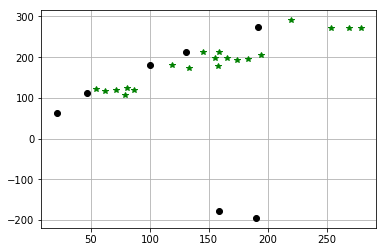

In [5]:
plt.plot(d['pC'],d['qC'],'ko',d['pE'],-1*d['qE'],'ko',d['po'],d['qo'],'g*')
plt.grid()
plt.savefig('pmc3.pdf')
plt.show()

In [6]:
P1 = {}
P2 = {}

## Separate points in 2 planes

In [7]:
for i in ('p','q','t'):
    # ???? Why do we need to re-write the same piece of code as in pmc2.py ?
    key = i+'C'
    P1[key] = d[key][d['pC'] >= bpC]
    P2[key] = d[key][d['pC'] <= bpC]
    
    key = i+'E'
    P1[key] = d[key][d['pE'] >= bpE]
    P2[key] = d[key][d['pE'] <= bpE]
    
    key = i+'o'
    P1[key] = d[key][d['s1o'] <  2*d['s2o']]
    P2[key] = d[key][d['s1o'] >= 2*d['s2o']]
    
    P1[i+'tot'] = np.concatenate((P1[i+'C'],P1[i+'E'],P1[i+'o']))
    P2[i+'tot'] = np.concatenate((P2[i+'C'],P2[i+'E'],P2[i+'o']))
    
P1['ttot']*=pi/180
P2['ttot']*=pi/180

## Solving plane equations

In [8]:
for P in (P1,P2):
    a = P['qtot']*np.sin(P['ttot'])
    
    A = np.ndarray((P['ptot'].shape[0],3))
    A[:,0] = P['ptot']
    A[:,1] = a
    A[:,2] = 1
    
    b = P['qtot']*np.cos(P['ttot'])
    
    P['x'] = np.linalg.pinv(A)@b

In [9]:
for P in (P1,P2):
    bc = P['x'][2]
    k = P['x'][1]
    P['Vo'] = bc/P['x'][0]
    be = 2*bc/(1-sqrt(3)*k)
    P['phyC'] = math.asin(3*bc/(6*P['Vo']+bc))
    P['phyE'] = math.asin(3*be/(6*P['Vo']-be))
    P['Sol'] = np.array([bc, be, k, P['Vo'], P['phyC']*180/pi, P['phyE']*180/pi])

In [10]:
#for P in (P1,P2): #old way
#    phyCP = P['phyC']
#    phyEP = P['phyE']
#    VoP = P['Vo']
#    P['qCfit'] = lambda x :(6*sin(phyCP)/(3-sin(phyCP)))*x+(6*VoP*tan(phyCP)*cos(phyCP)/(3-sin(phyCP)));
#    P['qEfit'] = lambda x : -(6*sin(phyEP)/(3+sin(phyEP)))*x-(6*VoP*tan(phyEP)*cos(phyEP)/(3+sin(phyEP)));
    
def qCfit(P,x):
    phyCP = P['phyC']
    phyEP = P['phyE']
    VoP = P['Vo']
    return (6*sin(phyCP)/(3-sin(phyCP)))*x+(6*VoP*tan(phyCP)*cos(phyCP)/(3-sin(phyCP)));

def qEfit(P,x):
    phyCP = P['phyC']
    phyEP = P['phyE']
    VoP = P['Vo']
    return -(6*sin(phyEP)/(3+sin(phyEP)))*x-(6*VoP*tan(phyEP)*cos(phyEP)/(3+sin(phyEP)));
                            
    

## Some Error computations

In [11]:
for P in (P1,P2): #curently not in pmc.py
    dmeasC = P['qC']
    dpredC = qCfit(P,P['pC'])
    P['SC'] = np.sum((np.abs(dmeasC-dpredC))/dmeasC)
    P['MAPEC'] = (1/P['pC'].shape[0])*P['SC']*100 if P['pC'].shape[0] != 0  else 0.0
    
    dmeasE = P['qE']
    dpredE = -qEfit(P,P['pE'])
    P['SE'] = np.sum((np.abs(dmeasE-dpredE))/dmeasE)
    P['MAPEE'] = (1/P['pE'].shape[0])*P['SE']*100 if P['pE'].shape[0] != 0  else 0.0

In [12]:
# Compute planes angles information

In [13]:
for P in (P1,P2):
    P['Nc'] = (1-sin(P['phyC']))/(2*sin(P['phyC']))
    P['Ne'] = (1-sin(P['phyE']))/(2*sin(P['phyE']))
    
    #P['sig1'] = lambda x,y : (1/P['Nc'])*(P['Vo']+P['Nc']*x+P['Ne']*(y-x)+y)

def sig1(P,x,y):
    return (1/P['Nc'])*(P['Vo']+P['Nc']*x+P['Ne']*(y-x)+y)

## Plane equations constant

In [14]:
for P in (P1,P2):
    P['A'] = ((1-sin(P['phyC']))/(2*sin(P['phyC'])))/P['Vo']
    P['B'] = ((sin(P['phyC'])-sin(P['phyE']))/(2*sin(P['phyC'])*sin(P['phyE'])))/P['Vo']
    P['C'] = -((1+sin(P['phyE']))/(2*sin(P['phyE'])))/P['Vo']
    
    

In [15]:
def get_z_pmc(P,sigma_num,configuration,x,y):
    Vo = P['Vo']
    A, B, C = P['A'], P['B'], P['C']
    if configuration == 'x':
        if sigma_num == 1:
            return (1/A)*(1-x*B-y*C)
        elif signma_num == 2:
            return (1/B)*(1-x*A-y*C)
        elif signma_num == 3:
            return (1/C)*(1-x*A-y*B)
    elif configuration == 'y':
        if sigma_num == 1:
            return (1/A)*(1-y*B-x*C)
        elif signma_num == 2:
            return (1/B)*(1-y*A-x*C)
        elif signma_num == 3:
            return (1/C)*(1-y*A-x*B)
    

In [16]:
conf_cycle = [1,2,3,3,2,1]
form_cycle = ['x','y']

def get_plane_n(P,num):
    return get_plane(P,conf_cycle[num%6],form_cycle[(num//3)%2])

def get_plane(P,sigma,form):
    P_coef = [P['A'],P['B'],P['C']]
    normal = np.zeros(3)
    normal[2] = P_coef[sigma-1]
    del P_coef[sigma-1]
    if form == 'y':
        P_coef = P_coef[::-1]
        # P_coef = [P_coef[1],P_coef[0]]
    normal[:2] = P_coef
    #origin = 1/(normal*3)
    
    return normal #origin

In [17]:
get_plane_n(P1,0)

array([ 0.00185949, -0.02575906,  0.00750689])

In [24]:
data[data[:,-1] == 0 and data[:,3] == 110]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [32]:
data[np.logical_and(data[:,-1] == 0, data[:,3] <= 110)]

array([[ 62.8,   0. ,   0. ,  20.9,  62.8,   0. ],
       [121.1,  10. ,  10. ,  47. , 111.1,   0. ],
       [221.3,  40. ,  40. , 100.4, 181.3,   0. ]])

In [40]:
is_C = data[:,-1] == 0
is_P2_C = data[:,3] <= 110

In [41]:
is_in_P2_C = np.logical_and(is_C,is_P2_C)

In [42]:
P2_C = data[is_in_P2_C]

In [43]:
P2_C

array([[ 62.8,   0. ,   0. ,  20.9,  62.8,   0. ],
       [121.1,  10. ,  10. ,  47. , 111.1,   0. ],
       [221.3,  40. ,  40. , 100.4, 181.3,   0. ]])

In [44]:
np.linalg.norm(P2_C[:,3])

112.80944109426304

In [49]:
pts_P2 = P2_C[:,:3].transpose()

In [50]:
pts_P2

array([[ 62.8, 121.1, 221.3],
       [  0. ,  10. ,  40. ],
       [  0. ,  10. ,  40. ]])